## Self attention

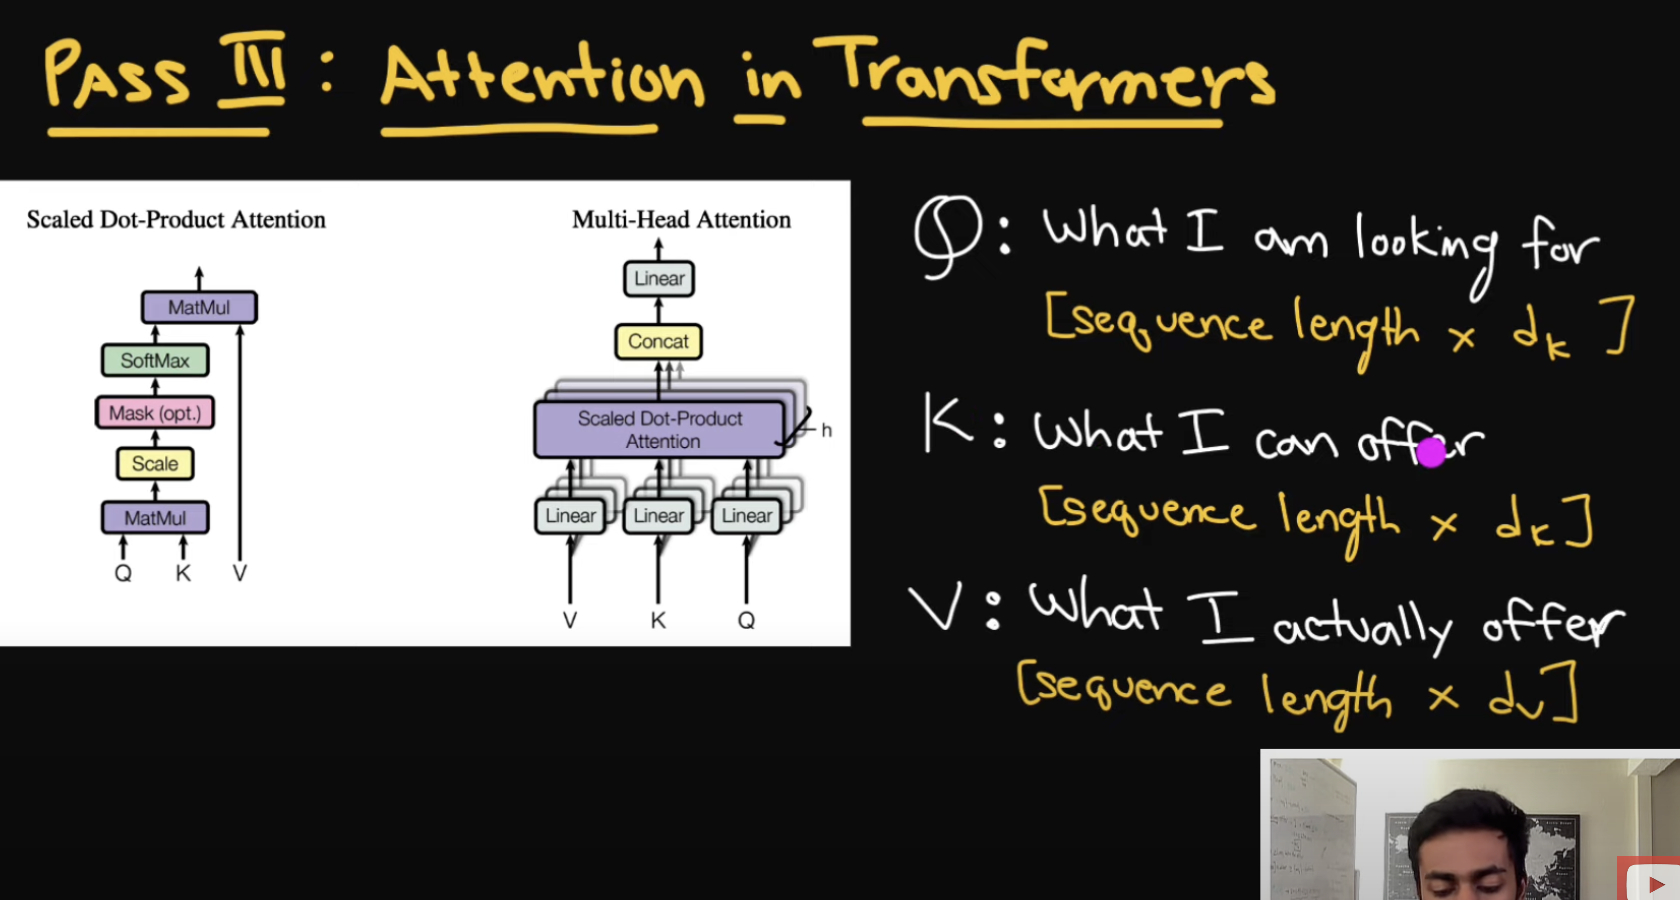

In [11]:
import numpy as np
import math
import torch
import torch.nn
import torch.nn as nn
import torch.nn.functional as F

In [12]:
import numpy as np
import math

L, d_k, d_v = 4, 8, 8   # L-> size of input and d_v and d_k is length of vector
q = np.random.randn(L,d_k)   # what i am lookling for
k = np.random.randn(L,d_k)   # what i can offer
v = np.random.randn(L,d_v)   # what i actually offer

### self attention

In [13]:

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=0)

def mask():
    maskMat = np.tril(np.ones((L,L)))
    maskMat[maskMat == 0] = -np.infty
    maskMat[maskMat == 1] = 0
    return maskMat

def scaled_dot_product_attention(q,k,v, mask=None):
    d_k = q.shape[-1]
    scaled = np.matmul(q,k.T) / math.sqrt(d_k)
    if mask is not None:
        scaled =  scaled + mask()
    
    attention = softmax(scaled)

    out = np.matmul(attention, v)
    return out,attention


In [14]:
values,attention = scaled_dot_product_attention(q,k,v,mask = None)
# print("Q\n ",q)
# print("K\n ",k)
# print("V\n ",v)
print('NEW V\n',values)
print('Attention\n',attention)

NEW V
 [[ 0.89432285  0.04513053  0.89175056  1.10808294  0.65495095 -0.52876739
   0.35028628  0.55539343]
 [ 0.24174138 -0.09349706 -0.0662363   0.05016459  0.12096622  0.04958347
  -0.01883902 -0.07516158]
 [ 0.14979837  0.06472133 -0.03690638  0.14142639  0.18126378  0.15491798
   0.10718878  0.01994594]
 [ 0.45167145 -0.06555636 -0.04319107  0.26650576  0.36970423  0.22263914
   0.09717849 -0.12234344]]
Attention
 [[0.79942867 0.19451158 0.05567226 0.80606967]
 [0.03536261 0.18443514 0.29195446 0.01158062]
 [0.05737048 0.1979088  0.14047873 0.01091467]
 [0.10783825 0.42314448 0.51189455 0.17143505]]


In [15]:
values,attention = scaled_dot_product_attention(q,k,v,mask = mask)
print(values)
print(attention)

[[ 0.95049873 -0.10140189  0.57138972  0.62888251  0.24101773 -0.95249599
   0.06272483  0.83506056]
 [ 0.01265881  0.23642341 -0.0512381   0.20231677  0.24000573  0.33157924
   0.23819252  0.07013686]
 [ 0.20221001  0.04249983 -0.06729188  0.1414336   0.20601997  0.17673025
   0.09995601 -0.0038632 ]
 [ 0.57216651 -0.2267229   0.29255708  0.59354681  0.63984175  0.34255971
   0.13494117 -0.52349986]]
[[0.79942867 0.         0.         0.        ]
 [0.03536261 0.22897305 0.         0.        ]
 [0.05737048 0.24570037 0.2153349  0.        ]
 [0.10783825 0.52532658 0.7846651  1.        ]]


# multihead attention

In [16]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, d_model, nums_head):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.nums_head = nums_head
        self.head_dim = d_model // nums_head
        self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def scaled_dot_product(self,q, k, v, mask = None):
        d_k = q.size()[-1]
        scaled = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)
        if mask is not None:
            scaled +=mask
        
        attention = F.softmax(scaled, dim = -1)
        values = torch.matmul(attention, v)
        return values, attention
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.nums_head, 3 * self.head_dim)
        qkv = qkv.permute(0,2,1,3)
        q, k, v = qkv.chunk(3, dim = -1)

        values, attention = self.scaled_dot_product(q,k,v, mask)
        print("Attention shape : ",attention.shape)
        values = values.reshape(batch_size, sequence_length, self.nums_head * self.head_dim)
        out = self.linear_layer(values)
        print("output shape : ",out.shape)

        return out

In [17]:
input_dim = 512
d_model =  512
nums_head = 8
batch_size = 1
sequence_length = 4
x = torch.randn(batch_size, sequence_length, input_dim)

model = MultiheadAttention(input_dim, d_model, nums_head)
put = model.forward(x)


Attention shape :  torch.Size([1, 8, 4, 4])
output shape :  torch.Size([1, 4, 512])


# Positioning Encoding

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.d_model = d_model
        self.max_sequence_length = max_sequence_length
    
    def forward(self):
        even_i = torch.arange(0,self.d_model,2).float()     # even positions
        odd_i = torch.arange(1,self.d_model,2).float()      # odd positions
        denominator = torch.pow(10000,(odd_i -1 )/ d_model)   
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length,1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)

        stacked = torch.stack([even_PE,odd_PE],dim = 2)   # one for seq and one for d_model
        PE = torch.flatten(stacked , start_dim=1, end_dim=2)
        return PE
        
        

In [19]:
model = PositionalEncoding(6,4)
PE = model.forward()
PE

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.8219,  0.5697,  0.8020,  0.5974],
        [ 0.9093, -0.4161,  0.9364, -0.3509,  0.9581, -0.2863],
        [ 0.1411, -0.9900,  0.2451, -0.9695,  0.3428, -0.9394]])

# Layer Normalization

In [20]:

class LayerNormalization():
    def __init__(self, parameter_shape, eps = 1e-5):
        self.parameter_shape = parameter_shape
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(parameter_shape))
        self.beta = nn.Parameter(torch.zeros(parameter_shape))

    def forward(self, input):
        dims = [-(i+1) for i in range(len(self.parameter_shape))]
        mean = inputs.mean(dim = dims, keepdim = True)
        var = ((inputs-mean)**2).mean(dim = dims, keepdim = True)
        std = (var + self.eps).sqrt()
        y = (input - mean) / std
        out = self.gamma * y + self.beta
        return out

# Encoder

In [21]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200    # fixed length for all input
ffn_hidden = 2048            # inside feed forward 
num_layers = 5